In [3]:
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import statsmodels.api as sm
import numpy as np
import geopandas as gpd
from matplotlib import pyplot as plt
import matplotlib.ticker
from haversine import haversine_vector, Unit
pd.options.mode.chained_assignment = None  # default='warn'
from sttn.data.lehd import OriginDestinationEmploymentDataProvider
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
provider = OriginDestinationEmploymentDataProvider()
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split
import scipy.optimize as optimize
import seaborn as sns

import math
from sttn.network import SpatioTemporalNetwork
from sttn.utils import add_distance
import os
%matplotlib inline

In [91]:
cities = [
    ('New York City', 'ny', [
        'Kings County, NY','Queens County, NY', 'New York County, NY','Bronx County, NY',
'Richmond County, NY','Westchester County, NY','Bergen County, NJ','Hudson County, NJ',
'Passaic County, NJ','Putnam County, NY','Rockland County, NY','Suffolk County, NY',
'Nassau County, NY','Middlesex County, NJ','Monmouth County, NJ','Ocean County, NJ',
'Somerset County, NJ','Essex County, NJ','Union County, NJ','Morris County, NJ',
'Sussex County, NJ','Hunterdon County, NJ','Pike County, PA',]),
    
    ('Los Angeles', 'ca', ['Los Angeles County, CA','Orange County, CA']),
    
    ('Chicago', 'il', [
        'Cook County, IL','DeKalb County, IL','DuPage County, IL','Grundy County, IL',
'Kankakee County, IL','Kane County, IL','Kendall County, IL','McHenry County, IL',
'Will County, IL','Jasper County, IN','Lake County, IN','Newton County, IN',
'Porter County, IN','Lake County, IL', 'Kenosha County, WI'
    ]),
    
    ('Houston', 'tx', ['Harris County, TX','Austin County','Brazoria County, TX',
'Chambers County, TX','Fort Bend County, TX','Galveston County, TX','Harris County, TX',
'Liberty County, TX','Montgomery County, TX','Waller County']),
    
    ('Boston', 'ma', ['Suffolk County, MA','Plymouth County, MA',
                      'Norfolk County, MA','Essex County, MA', 'Middlesex County, MA',
                     'Rockingham County, NH', 'Strafford County, NH']),

    ('Phoenix', 'az', ['Maricopa County, AZ','Pinal County, AZ','Gila County, AZ']),
    ('Philadelphia', 'pa', ['Burlington County, NJ','Camden County, NJ','Gloucester County,NJ',
     'Bucks County, PA', 'Chester County, PA', 'Montgomery County, PA',
                           'Delaware County, PA', 'Philadelphia County, PA',
                           'New Castle County, DE', 'Cecil County, MD', 'Salem County, NJ']),
    
    ('San Antonio', 'tx', ['Bexar County, TX','Atascosa County, TX','Bandera County, TX','Comal County, TX',
                          'Guadalupe County, TX','Kendall County, TX','Medina County, TX','Wilson County, TX']),
    
#     ('San Diego', 'ca', ['San Diego County, CA']),
    
    ('Dallas', 'tx', ['Collin County, TX','Dallas County, TX','Denton County, TX','Ellis County, TX',
'Hunt County, TX','Kaufman County, TX','Rockwall County, TX','Johnson County, TX','Parker County, TX',
'Tarrant County, TX','Wise County, TX']),
    
#     ('San Jose', 'ca', ['Santa Clara County, CA']),
#     ('Austin', 'tx', ['Travis County, TX','Williamson County, TX','Hays County, TX','Bastrop County, TX']),
]

In [92]:
def build_training_set(network, target_column):
    # explode the dataset to include all node pairs
    node_ids = network.nodes.index.values
    origins = pd.DataFrame(node_ids, columns = ['origin'])
    destinations = pd.DataFrame(node_ids, columns = ['destination'])
    cartesian_product = origins.merge(destinations, how='cross')
    
    # compute distnace between all pairs
    centroid = network.nodes.centroid
    centroid_long = centroid.x
    centroid_long.name = 'long'
    centroid_lat = centroid.y
    centroid_lat.name = 'lat'
    centroids = pd.concat([centroid_long, centroid_lat], axis=1)
    centroid_from = cartesian_product.join(centroids, on=network._origin).rename(columns={'long': 'long_from', 'lat': 'lat_from'})
    centroid_all = centroid_from.join(centroids, on=network._destination).rename(columns={'long': 'long_to', 'lat': 'lat_to'})
    from_points = list(zip(centroid_all.lat_from, centroid_all.long_from))
    to_points = list(zip(centroid_all.lat_to, centroid_all.long_to))
    centroid_all['distance'] = haversine_vector(from_points, to_points, Unit.KILOMETERS)
    centroid_all.drop(['long_from', 'lat_from', 'long_to', 'lat_to'], axis=1, inplace=True)
#     print(centroid_all.columns)
    centroid_above = centroid_all.loc[centroid_all.distance > 0]
    centroid_below = centroid_all.loc[centroid_all.distance == 0]
    del centroid_below['distance']
    misDistance = centroid_above.groupby(['origin']).agg({'distance':min})
    misDistance['distance'] = misDistance['distance']
    centroid_below = centroid_below.merge(misDistance,on=['origin'])
#     centroid_all.loc[centroid_all.distance == 0, 'distance'] = centroid_all.loc[centroid_all.distance > 0, 'distance'].min()*0.5
    centroid_all = pd.concat([centroid_above,centroid_below],axis=0)
    # compute jobs and residence
    comp_aggs={target_column: 'sum'}
    jobs = network.agg_adjacent_edges(aggs=comp_aggs, outgoing=False).rename(columns={target_column: 'jobs'})
    residence = network.agg_adjacent_edges(aggs=comp_aggs, outgoing=True).rename(columns={target_column: 'residence'})
    features = centroid_all.join(residence, on='origin').join(jobs, on='destination')
    
    # merge flow data
    flow = network.edges.rename(columns={target_column: 'flow'})[['origin', 'destination', 'flow']]
    combined = features.merge(flow, how='left', on=['origin', 'destination']).fillna(0)
    
    return combined

In [ ]:
# change here to age groups
target_columns = ['S000','SE01','SE03']
for city, state, conties in cities:
    
    print(city)
    state_network = provider.get_data(state=state, year=2018)
    city_network = state_network.filter_nodes(state_network.nodes.county.isin(conties))
    for target_column in target_columns:
        training_set = build_training_set(city_network, target_column)
        training_set.to_csv(f'{target_column}/{city}.csv',index=False)

In [51]:
for city, state, conties in cities:
    df0 = pd.read_csv(f'S000/{city}.csv')
    df1 = pd.read_csv(f'SE01/{city}.csv')
    df3 = pd.read_csv(f'SE03/{city}.csv')
    df0.rename(columns={'jobs':'S000jobs', 'residence':'S000residence','flow':'S000flow'}, inplace=True)
    df1.rename(columns={'jobs':'SE01jobs', 'residence':'SE01residence','flow':'SE01flow'}, inplace=True)
    df3.rename(columns={'jobs':'SE03jobs', 'residence':'SE03residence','flow':'SE03flow'}, inplace=True)
    merged = df0.merge(df1,on=['origin','destination'],how='outer').merge(df3,on=['origin','destination'],how='outer')
    merged.to_csv(f'income/{city}.csv', index=False)

# baseline

### unconstrain model, power law

In [94]:
def power_law(x,k,a):
    return k*((x[:,0]**a)*x[:,1]*x[:,2])
def baseline_fit(df,target):
    X = ['distance',target+'jobs',target+'residence']
    y = target+'flow'
    pars, cov = optimize.curve_fit(f=power_law, xdata=df[X].values, ydata=df[y].values, bounds=(-np.inf, np.inf))
    return pars
def baseline_predict(test,target,pars):
    test[target+'k'] = pars[0]
    test[target+'a'] = pars[1]
    test[target+'pred'] = test[target+'k']*(test['distance']**test[target+'a'])*test[target+'jobs']*test[target+'residence']
    return test

## f(d)

In [95]:
def unconstrained_bucked_constant_kfit(data, target):
    binf = {}
    X = data[target+'jobs'].values*data[target+'residence'].values
    y = data[target+'flow'].values
    model = sm.OLS(y,X)
    results = model.fit()
    k = results.params[0]
    data[target+'k'] = k
    # estimate F for each bin
    for b in data['bin'].unique():
        subData = data[data['bin'] == b]
        X = subData[target+'k']*subData[target+'jobs'].values*subData[target+'residence'].values
        y = subData[target+'flow'].values
        model = sm.OLS(y,X)
        results = model.fit()
        subData[target+'f'] = results.params[0]
        binf[b] = results.params[0]
    return (binf,k)
def unconstrained_bucked_constant_kpredict(test,target,k,binf):
    test[target+'k'] = k
    test[target+'f'] = test['bin'].apply(lambda x:binf[x])
    test[target+'pred'] = test[target+'k']*test[target+'f']*test[target+'jobs']*test[target+'residence']
    return test

## Normalize bin

In [140]:
minValue = []
maxValue = []
for city, state, conties in cities:
    df = pd.read_csv(f'income/{city}.csv')
    df['distance'] = df['distance']/1.6
    minValue += [np.min(np.log(df.distance))]
    maxValue += [np.max(np.log(df.distance))]
#     df = pd.to_csv(f'income/{city}.csv',index=)
minValue = np.min(minValue)
maxValue = np.max(maxValue)
print(minValue,maxValue)

-2.5900184418179646 5.128145595871199


In [141]:
def locBin(x,distBin):
    if x >= distBin[0] and x <= distBin[-1]:
        for i,num in enumerate(distBin):
            if x >= distBin[i] and x<= distBin[i+1]:
                return i
    else:
        raise Exception(f'Can not find bin for {x}')

## find optimal bin

#### determined to use 40 bins from the figure above

In [190]:
# expand bin to include the nearest datapoints
def mergeBin(df,rate,number):
    df = df.sort_values(by=['distance']).reset_index(drop=True)
    pad = pd.DataFrame()
#     thre = max(int(0.0007*len(df)),1500)
    thre = max(int(0.002*len(df)),2000)
#     thre = max(int(rate*len(df)),number)

    for binNo in df.bin.unique():
        if len(df.loc[df['bin']==binNo]) < thre:
            indexes = df.loc[df['bin']==binNo].index.values.astype(int)

            addedVolume = thre - len(df.loc[df['bin']==binNo])
#             print(addedVolume)

            if indexes[0] > int(addedVolume/2):
                padTemp = df.iloc[indexes[0] - int(addedVolume/2): indexes[0]]
                padTemp = pd.concat([padTemp,df.iloc[indexes[-1]:indexes[-1] + int(addedVolume/2)]])
                padTemp['bin'] = binNo
#                 print(indexes[0] - int(addedVolume/2), indexes[0],indexes[-1],indexes[-1] + int(addedVolume/2), binNo)
            else:
                padTemp = df.iloc[:indexes[0]]
                padTemp = pd.concat([padTemp,df.iloc[indexes[-1]: addedVolume-indexes[0]+indexes[-1]]])
                padTemp['bin'] = binNo
#                 print(indexes[0],indexes[-1], addedVolume-indexes[0]+indexes[-1],binNo)
            pad = pd.concat([pad,padTemp])
    df = pd.concat([df,pad])
    return df

In [177]:

# arbitarily set bin=40

resultsfd40is = {}
resultsfd40os = {}
bindffDict = {}
resultsBaselineis = {}
resultsBaselineos = {}
fdworsecount = []
number = 2000
for rate in np.arange(0.0007,0.01,0.0001):
    fdworsecounttemp = 0
    for city, state, conties in cities:
        print(city)
        df = pd.read_csv(f'income/{city}.csv')
        df['distance'] = df['distance']/1.6
        df = df.loc[(df['distance']>0.5)&(df['distance']<50)]
        df['logDist'] = np.log(df['distance'])
        distBin = np.linspace(np.log(0.5),np.log(50),40+1)
        df['bin'] = df.logDist.apply(lambda x: locBin(x,distBin))
        df = mergeBin(df,rate,number)

        binfdf = pd.DataFrame()

        # fd
        for target in ['SE01','SE03','S000']:
            traindf, testdf = train_test_split(df, test_size=0.2)
            binf,k = unconstrained_bucked_constant_kfit(traindf, target)
            print(target)
            df_fdis = unconstrained_bucked_constant_kpredict(traindf,target,k,binf)
            df_fdos = unconstrained_bucked_constant_kpredict(testdf,target,k,binf)
            binfOrigin = df_fdis[['bin',target+'f']].drop_duplicates()
            bindDict = dict(zip(binfOrigin['bin'],binfOrigin[target+'f']))
            bindffDict[city] = bindffDict.get(city,[]) + [bindDict]
            resultsfd40is[city] = resultsfd40is.get(city,[])+ \
                    [mean_squared_error(df_fdis[target+'flow'],df_fdis[target+'pred'])]
            resultsfd40os[city] = resultsfd40os.get(city,[])+ \
                    [mean_squared_error(df_fdos[target+'flow'],df_fdos[target+'pred'])]

            fdmseis = mean_squared_error(df_fdis[target+'flow'],df_fdis[target+'pred'])
            fdmseos = mean_squared_error(df_fdos[target+'flow'],df_fdos[target+'pred'])
            print('is',round(fdmseis,2),
                  'os',round(fdmseos,2))
        # baseline 
            pars = baseline_fit(traindf,target)
            df_baselineis = baseline_predict(traindf,target,pars)
            df_baselineos = baseline_predict(testdf,target,pars)
            resultsBaselineis[city] = resultsBaselineis.get(city,[]) + \
                [mean_squared_error(df_baselineis[target+'flow'],df_baselineis[target+'pred'])]
            resultsBaselineos[city] = resultsBaselineos.get(city,[]) + \
                [mean_squared_error(df_baselineos[target+'flow'],df_baselineos[target+'pred'])]

            blmseis = mean_squared_error(df_baselineis[target+'flow'],df_baselineis[target+'pred'])
            blmseos = mean_squared_error(df_baselineos[target+'flow'],df_baselineos[target+'pred'])
            print('is',round(blmseis,2),
                  'os',round(blmseos,2))
            if fdmseos > blmseos:
                fdworsecounttemp += 1
    fdworsecount += [fdworsecounttemp]

New York City
SE01
is 0.45 os 0.5
is 0.46 os 0.49
SE03
is 1.89 os 2.03
is 1.92 os 2.05
S000
is 5.9 os 5.66
is 5.95 os 5.72
Los Angeles
SE01
is 0.8 os 0.84
is 0.83 os 0.86
SE03
is 2.19 os 2.78
is 2.31 os 2.88
S000
is 6.92 os 6.96
is 7.22 os 6.99
Chicago
SE01
is 1.29 os 1.41
is 1.34 os 1.36
SE03
is 5.23 os 6.19
is 6.8 os 7.35
S000
is 16.18 os 18.3
is 18.06 os 18.4
Houston
SE01
is 3.18 os 2.91
is 3.51 os 2.88
SE03
is 26.9 os 25.73
is 28.78 os 25.05
S000
is 70.93 os 72.14
is 74.38 os 71.54
Boston
SE01
is 4.14 os 3.94
is 4.18 os 3.94
SE03
is 15.18 os 15.3
is 15.41 os 15.3
S000
is 51.15 os 51.47
is 51.65 os 51.69
Phoenix
SE01
is 1.85 os 3.08
is 1.87 os 2.99
SE03
is 6.49 os 6.43
is 6.62 os 6.58
S000
is 23.83 os 21.93
is 24.19 os 21.99
Philadelphia
SE01
is 1.72 os 1.7
is 1.75 os 1.7
SE03
is 6.69 os 7.55
is 7.45 os 7.67
S000
is 20.92 os 24.01
is 22.08 os 23.33
San Antonio
SE01
is 8.5 os 8.63
is 8.54 os 8.63
SE03
is 23.65 os 22.5
is 24.37 os 22.84
S000
is 113.09 os 107.22
is 114.26 os 108.23
Dal

S000
is 18.18 os 19.76
is 20.21 os 20.73
Houston
SE01
is 2.91 os 4.54
is 3.0 os 4.92
SE03
is 25.9 os 31.26
is 26.84 os 32.92
S000
is 73.53 os 61.12
is 76.85 os 61.73
Boston
SE01
is 4.05 os 4.33
is 4.07 os 4.36
SE03
is 15.08 os 15.73
is 15.31 os 15.71
S000
is 50.46 os 54.33
is 50.91 os 54.66
Phoenix
SE01
is 2.13 os 1.97
is 2.12 os 1.94
SE03
is 6.24 os 7.42
is 6.38 os 7.52
S000
is 24.08 os 20.84
is 24.46 os 20.89
Philadelphia
SE01
is 1.74 os 1.64
is 1.76 os 1.64
SE03
is 6.87 os 6.69
is 7.59 os 7.12
S000
is 21.93 os 19.62
is 23.0 os 19.56
San Antonio
SE01
is 8.73 os 7.71
is 8.77 os 7.71
SE03
is 23.79 os 22.02
is 24.6 os 21.92
S000
is 110.24 os 118.46
is 111.47 os 119.38
Dallas
SE01
is 2.25 os 1.88
is 2.27 os 1.91
SE03
is 12.2 os 12.29
is 13.37 os 13.11
S000
is 36.32 os 39.59
is 38.24 os 41.67
New York City
SE01
is 0.51 os 0.51
is 0.51 os 0.5
SE03
is 2.02 os 2.02
is 2.05 os 2.04
S000
is 6.3 os 6.39
is 6.36 os 6.45
Los Angeles
SE01
is 1.14 os 1.21
is 1.17 os 1.22
SE03
is 2.93 os 3.98
is 3.0

KeyboardInterrupt: 

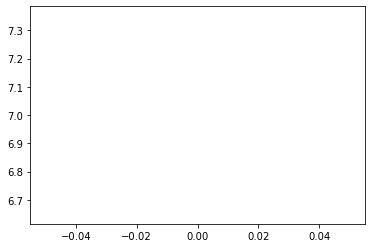

In [183]:
plt.plot(fdworsecount)

In [191]:

# arbitarily set bin=40

resultsfd40is = {}
resultsfd40os = {}
bindffDict = {}
resultsBaselineis = {}
resultsBaselineos = {}
fdworsecount = []
number = 2000
fdworsecounttemp = 0
rate = np.arange(0.0007,0.01,0.0001)[4]
for city, state, conties in cities:
    print(city)
    df = pd.read_csv(f'income/{city}.csv')
    df['distance'] = df['distance']/1.6
    df = df.loc[(df['distance']>0.5)&(df['distance']<50)]
    df['logDist'] = np.log(df['distance'])
    distBin = np.linspace(np.log(0.5),np.log(50),40+1)
    df['bin'] = df.logDist.apply(lambda x: locBin(x,distBin))
    df = mergeBin(df,rate,number)

    binfdf = pd.DataFrame()

    # fd
    for target in ['SE01','SE03','S000']:
        traindf, testdf = train_test_split(df, test_size=0.2)
        binf,k = unconstrained_bucked_constant_kfit(traindf, target)
        print(target)
        df_fdis = unconstrained_bucked_constant_kpredict(traindf,target,k,binf)
        df_fdos = unconstrained_bucked_constant_kpredict(testdf,target,k,binf)
        binfOrigin = df_fdis[['bin',target+'f']].drop_duplicates()
        bindDict = dict(zip(binfOrigin['bin'],binfOrigin[target+'f']))
        bindffDict[city] = bindffDict.get(city,[]) + [bindDict]
        resultsfd40is[city] = resultsfd40is.get(city,[])+ \
                [mean_squared_error(df_fdis[target+'flow'],df_fdis[target+'pred'])]
        resultsfd40os[city] = resultsfd40os.get(city,[])+ \
                [mean_squared_error(df_fdos[target+'flow'],df_fdos[target+'pred'])]

        fdmseis = mean_squared_error(df_fdis[target+'flow'],df_fdis[target+'pred'])
        fdmseos = mean_squared_error(df_fdos[target+'flow'],df_fdos[target+'pred'])
        print('is',round(fdmseis,2),
              'os',round(fdmseos,2))
    # baseline 
        pars = baseline_fit(traindf,target)
        df_baselineis = baseline_predict(traindf,target,pars)
        df_baselineos = baseline_predict(testdf,target,pars)
        resultsBaselineis[city] = resultsBaselineis.get(city,[]) + \
            [mean_squared_error(df_baselineis[target+'flow'],df_baselineis[target+'pred'])]
        resultsBaselineos[city] = resultsBaselineos.get(city,[]) + \
            [mean_squared_error(df_baselineos[target+'flow'],df_baselineos[target+'pred'])]

        blmseis = mean_squared_error(df_baselineis[target+'flow'],df_baselineis[target+'pred'])
        blmseos = mean_squared_error(df_baselineos[target+'flow'],df_baselineos[target+'pred'])
        print('is',round(blmseis,2),
              'os',round(blmseos,2))
        if fdmseos > blmseos:
            fdworsecounttemp += 1
fdworsecount += [fdworsecounttemp]

New York City
SE01
is 0.56 os 0.56
is 0.56 os 0.55
SE03
is 2.11 os 2.15
is 2.13 os 2.18
S000
is 6.84 os 6.68
is 6.89 os 6.75
Los Angeles
SE01
is 1.3 os 1.32
is 1.33 os 1.33
SE03
is 3.14 os 4.82
is 3.31 os 4.81
S000
is 11.24 os 10.97
is 11.52 os 11.02
Chicago
SE01
is 1.98 os 2.4
is 2.02 os 2.42
SE03
is 6.03 os 7.31
is 7.63 os 8.44
S000
is 20.75 os 22.16
is 22.7 os 23.44
Houston
SE01
is 3.13 os 3.16
is 3.48 os 3.06
SE03
is 27.27 os 24.62
is 29.11 os 24.35
S000
is 71.06 os 73.21
is 74.58 os 72.22
Boston
SE01
is 4.14 os 3.95
is 4.17 os 3.96
SE03
is 15.14 os 15.5
is 15.33 os 15.59
S000
is 51.55 os 49.92
is 52.1 os 49.91
Phoenix
SE01
is 2.14 os 1.9
is 2.13 os 1.91
SE03
is 6.49 os 6.44
is 6.63 os 6.54
S000
is 23.9 os 21.5
is 24.26 os 21.68
Philadelphia
SE01
is 1.7 os 1.79
is 1.72 os 1.8
SE03
is 6.84 os 7.1
is 7.62 os 6.99
S000
is 21.35 os 21.64
is 22.31 os 22.29
San Antonio
SE01
is 8.79 os 7.47
is 8.84 os 7.46
SE03
is 22.59 os 26.82
is 23.33 os 27.0
S000
is 112.11 os 111.08
is 113.58 os 111.0

In [194]:
fdworsecounttemp

9

In [192]:
msedffd = pd.DataFrame(resultsfd40is).T
msedffd.columns = [i+'fd' for i in ['SE01','SE03','S000']]

msedfbl = pd.DataFrame(resultsBaselineis).T
msedfbl.columns = [i+'bl' for i in ['SE01','SE03','S000']]

msedf = pd.concat([msedffd,msedfbl],axis=1)
msedf = msedf[sorted(msedffd.columns.tolist()+msedfbl.columns.tolist())]
msedf

,S000bl,S000fd,SE01bl,SE01fd,SE03bl,SE03fd
New York City,6.890034,6.838893,0.561207,0.559113,2.129165,2.105406
Los Angeles,11.521499,11.239333,1.331685,1.302802,3.313082,3.139041
Chicago,22.703550,20.745907,2.019338,1.977269,7.628095,6.026089
Houston,74.575682,71.055263,3.480270,3.130168,29.109182,27.273210
Boston,52.096664,51.554894,4.171953,4.138984,15.334976,15.136530
Phoenix,24.260683,23.902443,2.128337,2.135558,6.628849,6.494897
Philadelphia,22.313888,21.352495,1.721717,1.702275,7.621551,6.839748
San Antonio,113.579198,112.106118,8.837672,8.790854,23.333358,22.590769
Dallas,42.205563,40.221387,2.437492,2.408077,14.102182,13.027471


In [193]:
msedffd = pd.DataFrame(resultsfd40os).T
msedffd.columns = [i+'fd' for i in ['SE01','SE03','S000']]

msedfbl = pd.DataFrame(resultsBaselineos).T
msedfbl.columns = [i+'bl' for i in ['SE01','SE03','S000']]

msedf = pd.concat([msedffd,msedfbl],axis=1)
msedf = msedf[sorted(msedffd.columns.tolist()+msedfbl.columns.tolist())]
msedf

,S000bl,S000fd,SE01bl,SE01fd,SE03bl,SE03fd
New York City,6.752856,6.682985,0.553943,0.555277,2.176761,2.150899
Los Angeles,11.017453,10.973533,1.334391,1.321497,4.807529,4.821914
Chicago,23.440061,22.159031,2.422161,2.401438,8.436282,7.308909
Houston,72.216298,73.205999,3.057823,3.158090,24.347203,24.617972
Boston,49.914647,49.916437,3.958415,3.953778,15.590997,15.502270
Phoenix,21.681288,21.498416,1.908036,1.902071,6.543191,6.442596
Philadelphia,22.285706,21.641765,1.799864,1.785893,6.991262,7.095198
San Antonio,111.006594,111.080545,7.458193,7.471329,27.002259,26.815014
Dallas,46.146965,44.035116,2.813461,2.806247,14.816318,13.552662


In [195]:
# 0.2% / 2000

fig,ax = plt.subplots(4,3,figsize=(14,20))
i= 0
for city, state, conties in cities:
    df = pd.DataFrame({'bin':Distfd1[city].keys(),'fd':Distfd1[city].values()})
    df = df.sort_values(by='bin')
    ax[i//3,i%3].set_xlim(0.5,50)
    deltax = (list(Distfd1[city].keys())[-1] -\
     list(Distfd1[city].keys())[0])/len(Distfd1[city].keys())
    
    A = deltax/2*(np.array(list(Distfd1[city].values())[1:-1]).sum()+\
             list(Distfd1[city].values())[0]+\
             list(Distfd1[city].values())[-1])
    ax[i//3,i%3].plot(df['bin'],df['fd'],label='SE01, AUC = '+str(round(A,2)))

    df = pd.DataFrame({'bin':Distfd3[city].keys(),'fd':Distfd3[city].values()})
    df = df.sort_values(by='bin')
    
    A = deltax/2*(np.array(list(Distfd3[city].values())[1:-1]).sum()+\
         list(Distfd3[city].values())[0]+\
         list(Distfd3[city].values())[-1])
    
    ax[i//3,i%3].plot(df['bin'],df['fd'],label='SE03, AUC = '+str(round(A,2)))

    ax[i//3,i%3].set_title(city)
    ax[i//3,i%3].legend()
    ax[i//3,i%3].set_yscale('log')
    ax[i//3,i%3].set_xscale('log')
    ax[i//3,i%3].set_yticks([0.5, 1, 1.5, 3, 5, 10])
    ax[i//3,i%3].set_xticks([1, 2, 3, 5, 10, 20, 30, 50])
    ax[i//3,i%3].get_xaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())
    ax[i//3,i%3].get_yaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())
    ax[i//3,i%3].set_ylabel('f(d)')
    ax[i//3,i%3].set_xlabel('km')
    i += 1
      
plt.savefig('curve no smooth.png')

Error in callback <function flush_figures at 0x12c34c170> (for post_execute):


KeyboardInterrupt: 

In [196]:
# convert bins back to distance
Distfd1 = {}
Distfd3 = {}
Distfd0 = {}
for city in bindffDict.keys():
    income1 = bindffDict[city][0]
    income3 = bindffDict[city][1]
    income0 = bindffDict[city][2]
    distList = []
    fdList = []
    for bins in income1.keys():
        distList += [np.e**distBin[bins],np.e**distBin[bins+1]]
        fdList += [income1[bins],income1[bins]]
        fdDict = dict(zip(distList,fdList))
        Distfd1[city] = dict(sorted(fdDict.items()))
    distList = []
    fdList = []
    for bins in income3.keys():
        distList += [np.e**distBin[bins],np.e**distBin[bins+1]]
        fdList += [income3[bins],income3[bins]]
        fdDict = dict(zip(distList,fdList))
        Distfd3[city] = dict(sorted(fdDict.items()))
    for bins in income0.keys():
        distList += [np.e**distBin[bins],np.e**distBin[bins+1]]
        fdList += [income0[bins],income0[bins]]
        fdDict = dict(zip(distList,fdList))
        Distfd0[city] = dict(sorted(fdDict.items()))

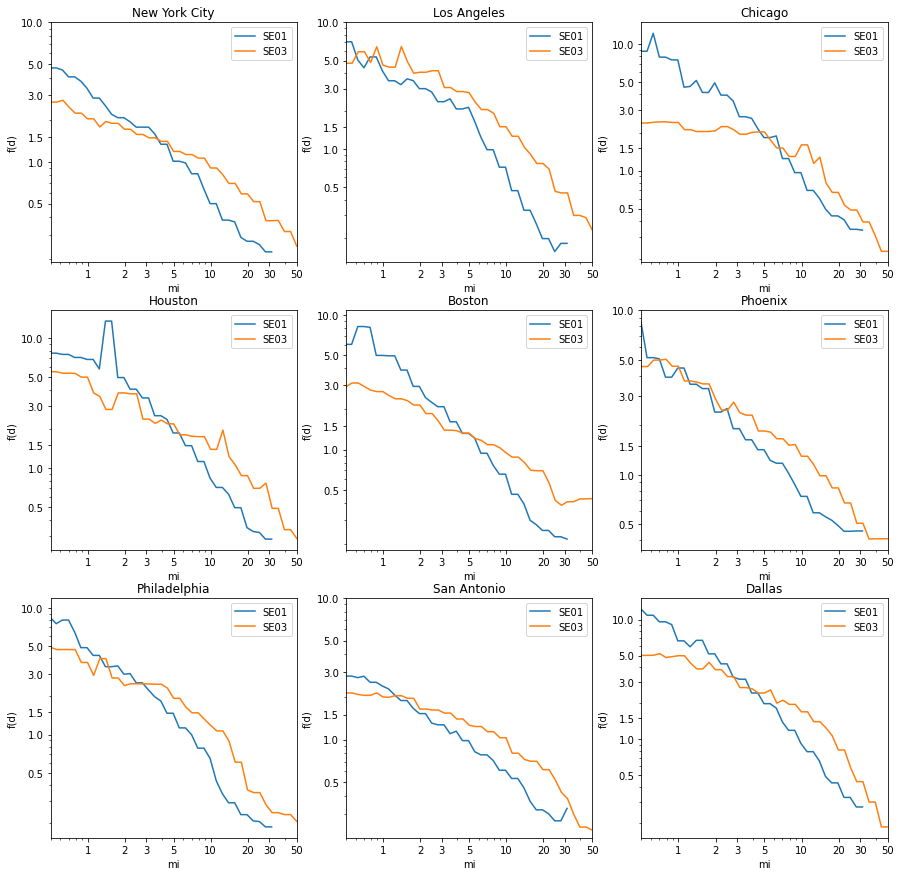

In [197]:
# 0.2% / 2000

fig,ax = plt.subplots(3,3,figsize=(15,15))
i= 0
for city, state, conties in cities:
    df = pd.DataFrame({'bin':Distfd1[city].keys(),'fd':Distfd1[city].values()})
    df = df.sort_values(by='bin')
    df.bin = df.bin/1.6
    ax[i//3,i%3].set_xlim(0.5,50)
    ax[i//3,i%3].plot(df['bin'],df['fd'],label='SE01')

    df = pd.DataFrame({'bin':Distfd3[city].keys(),'fd':Distfd3[city].values()})
    df = df.sort_values(by='bin')

    
    ax[i//3,i%3].plot(df['bin'],df['fd'],label='SE03')

    ax[i//3,i%3].set_title(city)
    ax[i//3,i%3].legend()
    ax[i//3,i%3].set_yscale('log')
    ax[i//3,i%3].set_xscale('log')
    ax[i//3,i%3].set_yticks([0.5, 1, 1.5, 3, 5, 10])
    ax[i//3,i%3].set_xticks([1, 2, 3, 5, 10, 20, 30, 50])
    ax[i//3,i%3].get_xaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())
    ax[i//3,i%3].get_yaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())
    ax[i//3,i%3].set_ylabel('f(d)')
    ax[i//3,i%3].set_xlabel('mi')
    i += 1
      
plt.savefig('curve.png')